In [1]:
import numpy as np
import matplotlib.pyplot as plt

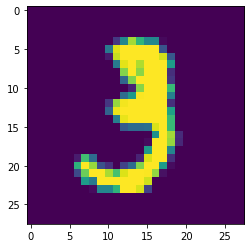

In [2]:
import urllib.request, urllib.parse, os.path, hashlib, gzip
from functools import reduce

data_dir = os.path.join(os.path.dirname(os.path.realpath("__file__")), 'data')
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

def get_mnist_data(url, base_url='http://yann.lecun.com/exdb/mnist/'):
    path = os.path.join(data_dir, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            dat = f.read()
    else:
        with urllib.request.urlopen(urllib.parse.urljoin(base_url, url)) as response:
            dat = response.read()

        with open(path, 'wb') as f:
            f.write(dat)

    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

size = (28, 28)
n_features, n_classes = np.prod(size), 10

X_train = get_mnist_data('train-images-idx3-ubyte.gz')[16:].reshape(-1, *size)
y_train = get_mnist_data('train-labels-idx1-ubyte.gz')[8:]
X_test = get_mnist_data('t10k-images-idx3-ubyte.gz')[16:].reshape(-1, *size)
y_test = get_mnist_data('t10k-labels-idx1-ubyte.gz')[8:]

# Test plot
plt.imshow(X_train[10]);

In [3]:
def gen_mini_batch_img(batch_size):
    idxs = np.random.randint(0, high=np.shape(X_train)[0], size=batch_size)
    return X_train[idxs].reshape(-1, 1, *size), y_train[idxs]

def gen_mini_batch(batch_size):
    X, y = gen_mini_batch_img(batch_size)
    return X.reshape((-1, n_features)), y

def one_hot(xs, n_classes=10):
    ys = np.zeros((xs.shape[0], n_classes))
    for i, x in enumerate(xs):
        ys[i, x] = 1
        
    return ys

In [4]:
import alsograd as ag
import alsograd.nn as nn
import alsograd.nn.activation as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.Linear(n_features, 128)
        self.l2 = nn.Linear(128, 32)
        self.l3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)

        return x

In [5]:
model = Net()

# Test inputs
x, y_true = np.random.rand(8, n_features), np.random.randint(0, 10, size=8)

# alsograd loss
y_pred = model.forward(ag.Parameter(x))
loss_ag = (-F.softmax(y_pred).log()*one_hot(y_true)).mean()*n_classes

# Torch loss
import torch as th
import torch.nn as th_nn

criterion = th_nn.CrossEntropyLoss()
loss_th = criterion(th.tensor(y_pred.data).float(), th.tensor(y_true).long())

assert (loss_th - loss_ag.data[0]).abs() < 1e-5

In [6]:
from alsograd.nn.optimizer import *

def get_acc(y_pred, y):
    return (np.argmax(y_pred, axis=1) == y).mean()

# Train
def train(optimizer, model, gen_batch, batch_size=512, n_epoch=5, n_batches=50):
    losses, accuracies = [], []

    for _ in range(n_epoch):
        for _ in range(n_batches):
            images, labels = gen_batch(batch_size)
            images, labels_oh = ag.Parameter(images), one_hot(labels)

            optimizer.zero_grad()

            y = model(images)
            acc = get_acc(y.data, labels)

            # Cross-entropy
            loss = (-F.softmax(y).log()*labels_oh).mean()*n_classes
            loss.backward()

            optimizer.step()

            # Process
            losses.append(loss)
            accuracies.append(acc)
            print('Loss: {:.3f}, acc: {:.3f}'.format(loss.data[0], acc), end="\r")

    return losses, accuracies
            
def plot_train_results(losses, accuracies):
    losses_np = [l.data[0] for l in losses]

    plt.plot(losses_np, label='Loss')
    plt.plot(accuracies, label='Accuracy')
    plt.ylim([0, 2])
    plt.legend()
    plt.grid()

batch_size = 1024
n_epoch, n_batches = 2, 100

In [7]:
# model = Net()
# # optimizer = SGD(model, learning_rate=1e-4)
# optimizer = AdaGrad(model, learning_rate=1e-3)

# losses, accuracies = train(optimizer, model, gen_mini_batch)
# plot_train_results(losses, accuracies)

In [8]:
class NetConv(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2D(1, 4, padding=1, kernel_size=5)
        self.mp1 = nn.MaxPool2D(kernel_size=(2, 2))
        self.c2 = nn.Conv2D(4, 8, padding=1, kernel_size=5)
        self.mp2 = nn.MaxPool2D(kernel_size=(2, 2))

        self.l1 = nn.Linear(200, 32)
        self.l2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.mp1(F.relu(self.c1(x)))
        x = self.mp2(F.relu(self.c2(x)))

        x = x.ravel(1)
        x = F.relu(self.l1(x))

        return self.l2(x)

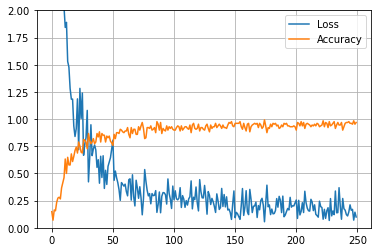

In [9]:
model = NetConv()
optimizer = SGD(model, learning_rate=1e-4, momentum=0.9)

losses, accuracies = train(optimizer, model, gen_mini_batch_img, batch_size=128)
plot_train_results(losses, accuracies)

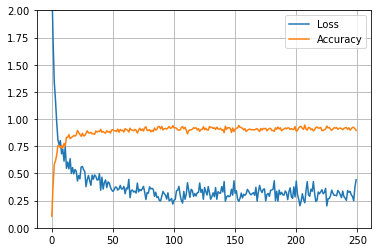

In [10]:
# Same thing as above FF net re-implemented using sequential
model = nn.Sequential([
    nn.Linear(n_features, 128),
    F.relu,
    nn.Linear(128, 32),
    F.relu,
    nn.Linear(32, 10)
])

optimizer = Adam(model, learning_rate=1e-3, momentum=0.9, beta=0.95)

losses, accuracies = train(optimizer, model, gen_mini_batch)
plot_train_results(losses, accuracies)